In [1]:
from tensorflow.keras import layers, models
import tensorflow as tf
import numpy as np

def get_model(input_length: int, max_peak_count: int) -> tf.keras.Model:
    """
    Build a fixed deep learning model for predicting peak positions and amplitudes,
    with a shared feature extraction trunk and two separate heads.

    Parameters
    ----------
    input_length : int
        Length of the input signal.
    max_peak_count : int
        Maximum number of peaks the model will predict.

    Returns
    -------
    tf.keras.Model
        The compiled Keras model for peak position and amplitude prediction.
    """
    # -- Input layer --
    input_layer = layers.Input(shape=(input_length, 1), name="input_signal")

    # -------------------------------------------------------------------------
    # 1) SHARED TRUNK
    # Keep the pooling moderate or minimal so we don't lose too much position resolution
    # -------------------------------------------------------------------------
    x = layers.Conv1D(filters=16, kernel_size=7, padding='same', activation='relu')(input_layer)
    x = layers.MaxPooling1D(pool_size=2)(x)   # downsampling by factor of 2

    x = layers.Conv1D(filters=32, kernel_size=5, padding='same', activation='relu')(x)
    x = layers.Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(x)

    # Instead of multiple large pool layers, use just one or two smaller ones.
    # This can help preserve enough resolution for position detection. 
    # If you still find positions off by 1-2 indices, reduce pooling further or remove entirely.

    # We'll do a global average pool to keep the final representation smaller,
    # but you can also flatten if you'd rather preserve all local features:
    x = layers.GlobalAveragePooling1D()(x)

    # -------------------------------------------------------------------------
    # 2) HEAD for POSITION
    # -------------------------------------------------------------------------
    # A small Dense stack for positions
    pos_head = layers.Dense(64, activation='relu')(x)
    # We'll use a sigmoid so output is in [0,1], then scale by input_length
    pos_head = layers.Dense(max_peak_count, activation='sigmoid')(pos_head)
    # Scale by input_length so predicted positions are in [0, input_length]
    position_output = layers.Lambda(lambda t: t * input_length, name='positions')(pos_head)

    # -------------------------------------------------------------------------
    # 3) HEAD for AMPLITUDE
    # -------------------------------------------------------------------------
    amp_head = layers.Dense(64, activation='relu')(x)
    # For amplitudes, we typically allow any real value, so 'linear' activation is fine
    amplitude_output = layers.Dense(max_peak_count, activation='linear', name='amplitudes')(amp_head)

    # -------------------------------------------------------------------------
    # Build & Compile the model
    # -------------------------------------------------------------------------
    model = models.Model(
        inputs=input_layer, 
        outputs=[position_output, amplitude_output], 
        name="position_amplitude_shared_trunk_model"
    )

    return model



In [2]:
# from DeepPeak import models
from DeepPeak.data.data_generation import generate_gaussian_dataset
from DeepPeak.utils.visualization import plot_training_history, visualize_validation_cases
from DeepPeak.utils.training_utils import dataset_split
from tensorflow.keras.callbacks import ModelCheckpoint # type: ignore
from tensorflow.keras.models import load_model  # type: ignore

In [109]:
# Call the function
slices, amplitudes, peak_count, positions, widths, _ = generate_gaussian_dataset(
    sample_count=3000,
    sequence_length=200,
    peak_count=(3, 3),
    amplitude_range=(3, 5),
    center_range=(0.1, 0.9),
    width_range=(0.02, 0.02),
    noise_std=0.1,
    normalize=False,
    normalize_x=True,
    categorical_peak_count=True,
    sort_peak='amplitude'
)

dataset = dataset_split(
    x=slices,
    positions=positions,
    amplitudes=amplitudes,
    peak_count=peak_count,
    widths=widths,
    test_size=0.2,
    random_state=None,
)


# np.all(dataset['train']['positions'][:, 2] <= dataset['train']['positions'][:, 3])

In [110]:
import numpy as np
from scipy.optimize import linear_sum_assignment


def permutation_invariant_loss(y_true, y_pred):
    # y_true and y_pred shape: (batch_size, max_peak_count)
    # Sort each row
    y_true_sorted = tf.sort(y_true, axis=1)
    y_pred_sorted = tf.sort(y_pred, axis=1)
    
    # Compute MSE between sorted arrays
    return tf.reduce_mean(tf.square(y_true_sorted - y_pred_sorted))

In [114]:
import tensorflow as tf
from tensorflow.keras import layers, models

def get_model(input_length: int, max_peak_count: int) -> models.Model:
    n_filter = 64
    kernel_size = 3
    
    input_layer = layers.Input(shape=(input_length, 1))
    
    x = layers.Conv1D(n_filter, kernel_size, padding='same', use_bias=False)(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    
    x = layers.Conv1D(n_filter * 2, kernel_size, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    
    x = layers.Conv1D(n_filter * 4, kernel_size, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    # Optionally add a dilated conv or another pooling, depending on signal length.
    x = layers.Conv1D(n_filter * 8, kernel_size, dilation_rate=2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Flatten()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)

    # Positions in [0,1] range -> multiply by input_length at inference to get actual indices
    output = layers.Dense(max_peak_count, activation='sigmoid', name="positions")(x)

    model = models.Model(inputs=input_layer, outputs=output)
    return model

# Then you might do:
# model = get_model(input_length=1024, max_peak_count=3)
# model.compile(optimizer='adam', loss='mse')
# model.summary()


In [115]:
from tensorflow import keras
keras.config.enable_unsafe_deserialization()
    
# Define the callback to save the best model
checkpoint_callback = ModelCheckpoint(
    filepath="best_model.keras",          # Path to save the best model
    monitor="val_loss",                # Metric to monitor (e.g., "val_loss" or "val_accuracy")
    save_best_only=True,               # Save only the best model
    save_weights_only=False,           # Save the entire model (set True to save only weights)
    mode="min",                        # "min" for loss (smaller is better), "max" for accuracy
    verbose=1                          # Display a message when saving the model
)


model = get_model(input_length=200, max_peak_count=3)

model.compile(
    optimizer='adam',
    loss={
        "positions": permutation_invariant_loss,
        # "amplitudes": "mse"
    },
)

history = model.fit(
    dataset['train']['x'],
    dataset['train']['positions'],
    epochs=500,
    batch_size=16,
    validation_split=0.2,
    callbacks=[checkpoint_callback],
    verbose=1
)

model = load_model("best_model.keras")

Epoch 1/500
119/120 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0388
Epoch 1: val_loss improved from inf to 0.01718, saving model to best_model.keras
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0386 - val_loss: 0.0172
Epoch 2/500
117/120 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0079
Epoch 2: val_loss improved from 0.01718 to 0.00825, saving model to best_model.keras
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0079 - val_loss: 0.0083
Epoch 3/500
119/120 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0041
Epoch 3: val_loss improved from 0.00825 to 0.00373, saving model to best_model.keras
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0041 - val_loss: 0.0037
Epoch 4/500
117/120 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0029
Epoch 4: val_loss improved from 0.00373 to 0.00193, saving model to best_model.keras
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 5/500
117/120 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0020
Epoch 5: val_lo

KeyboardInterrupt: 

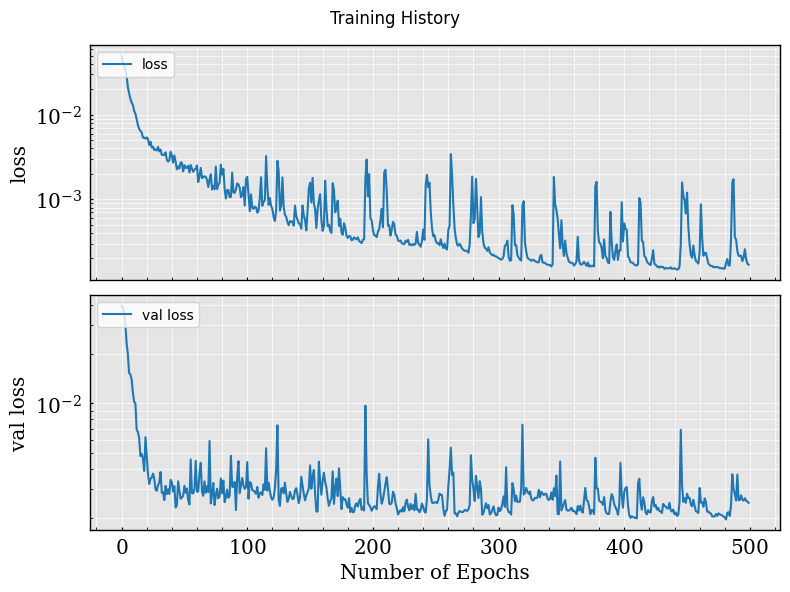

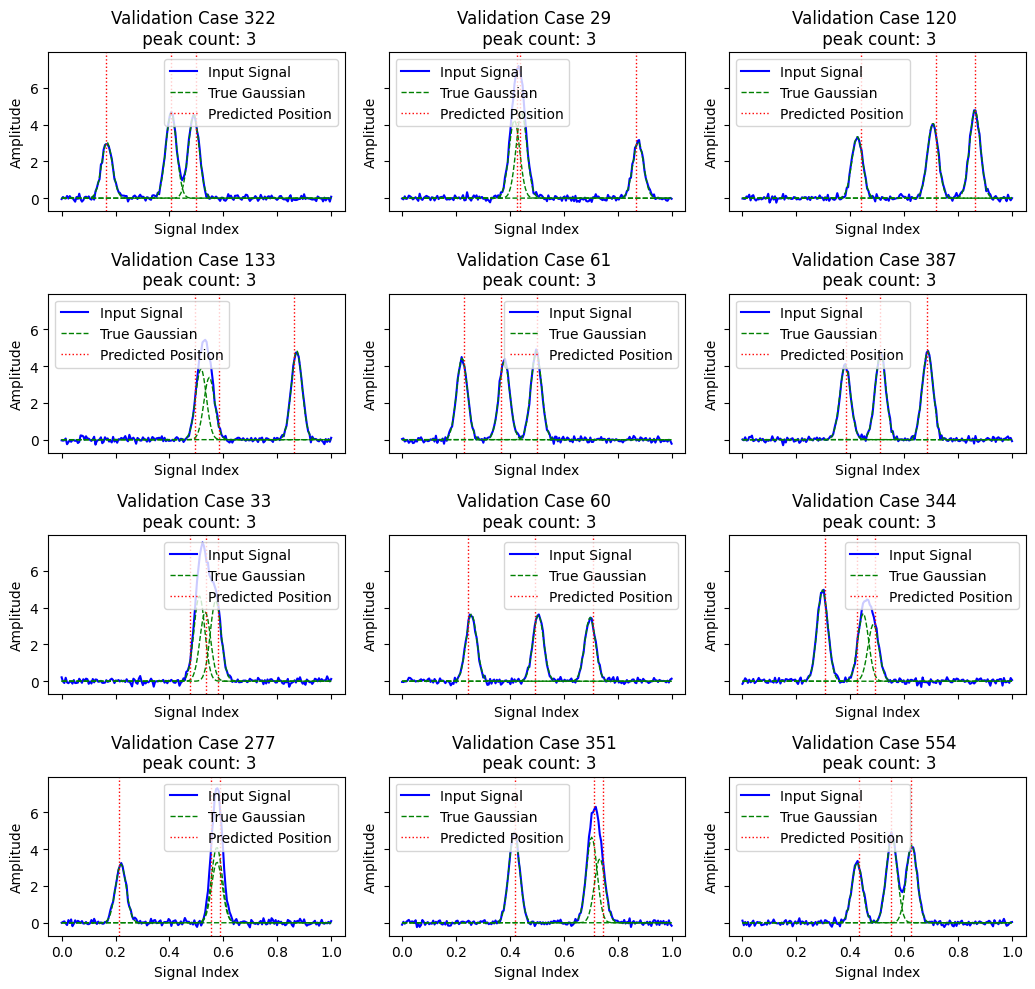

In [116]:
plot_training_history(history, filtering=['*loss*'])

visualize_validation_cases(
    model=model,
    validation_data=dataset['test'],
    sequence_length=200,
    num_examples=12,
    n_columns=3
)

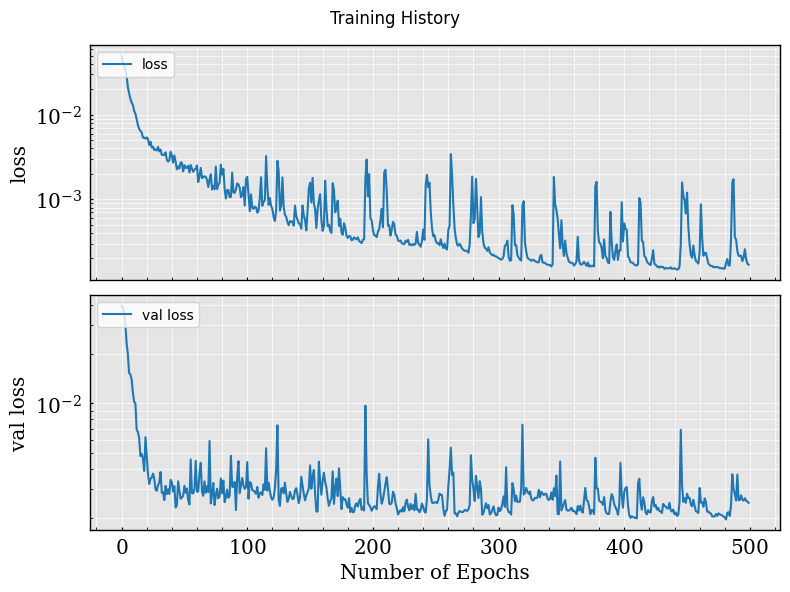

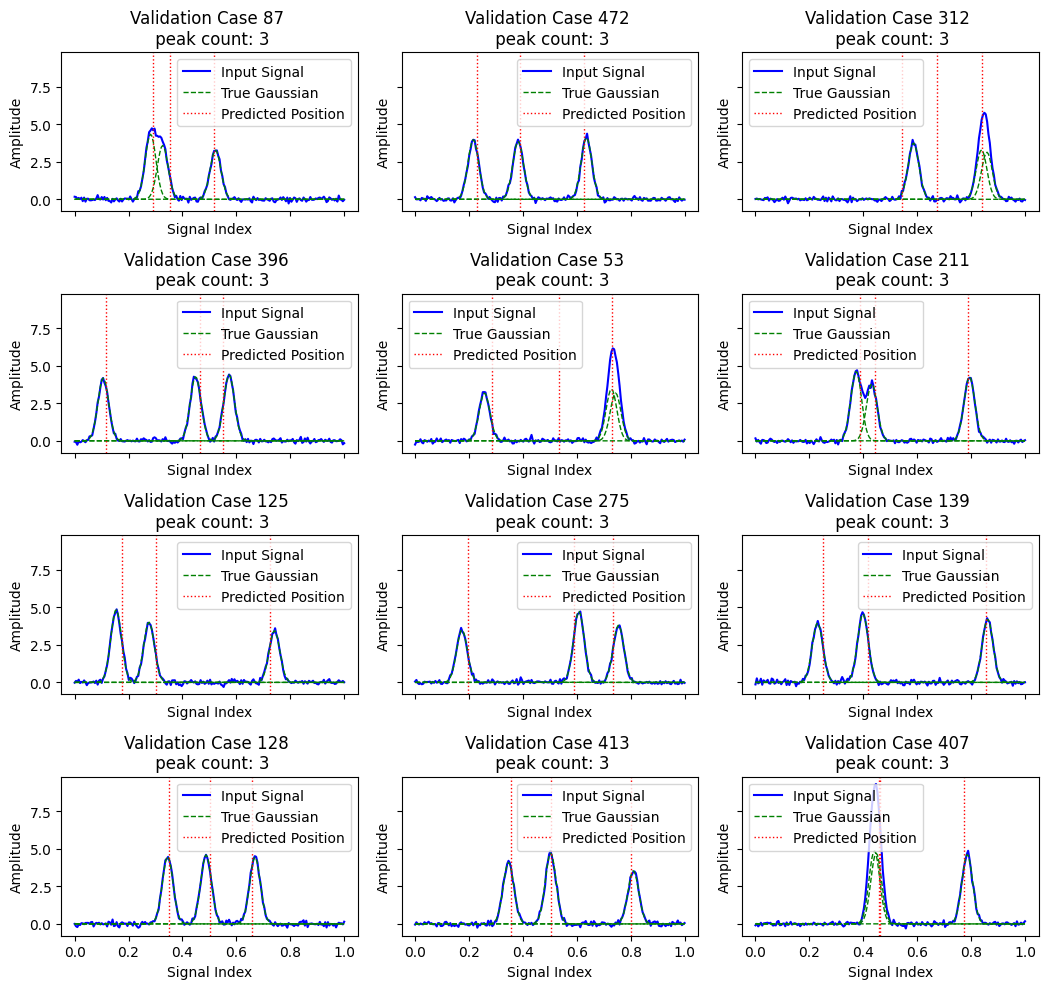

In [113]:

plot_training_history(history, filtering=['*loss*'])

visualize_validation_cases(
    model=model,
    validation_data=dataset['test'],
    sequence_length=200,
    num_examples=12,
    n_columns=3
)

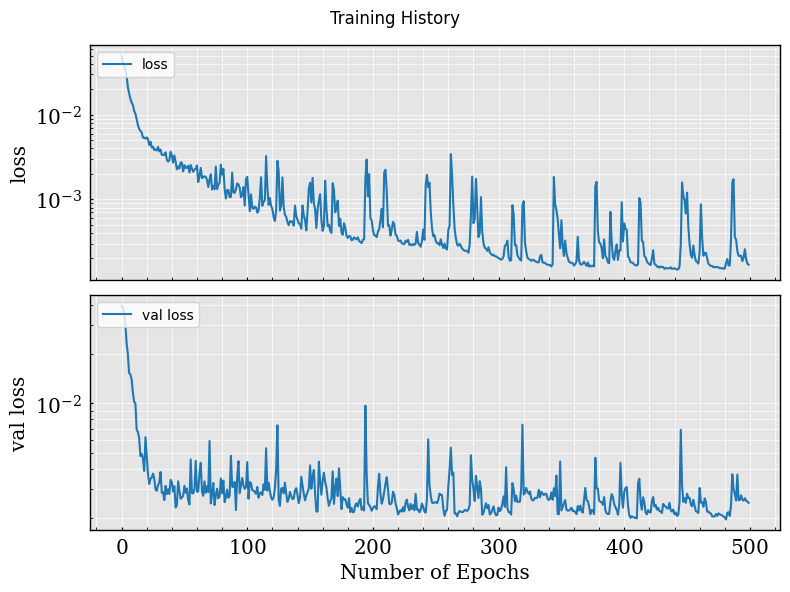

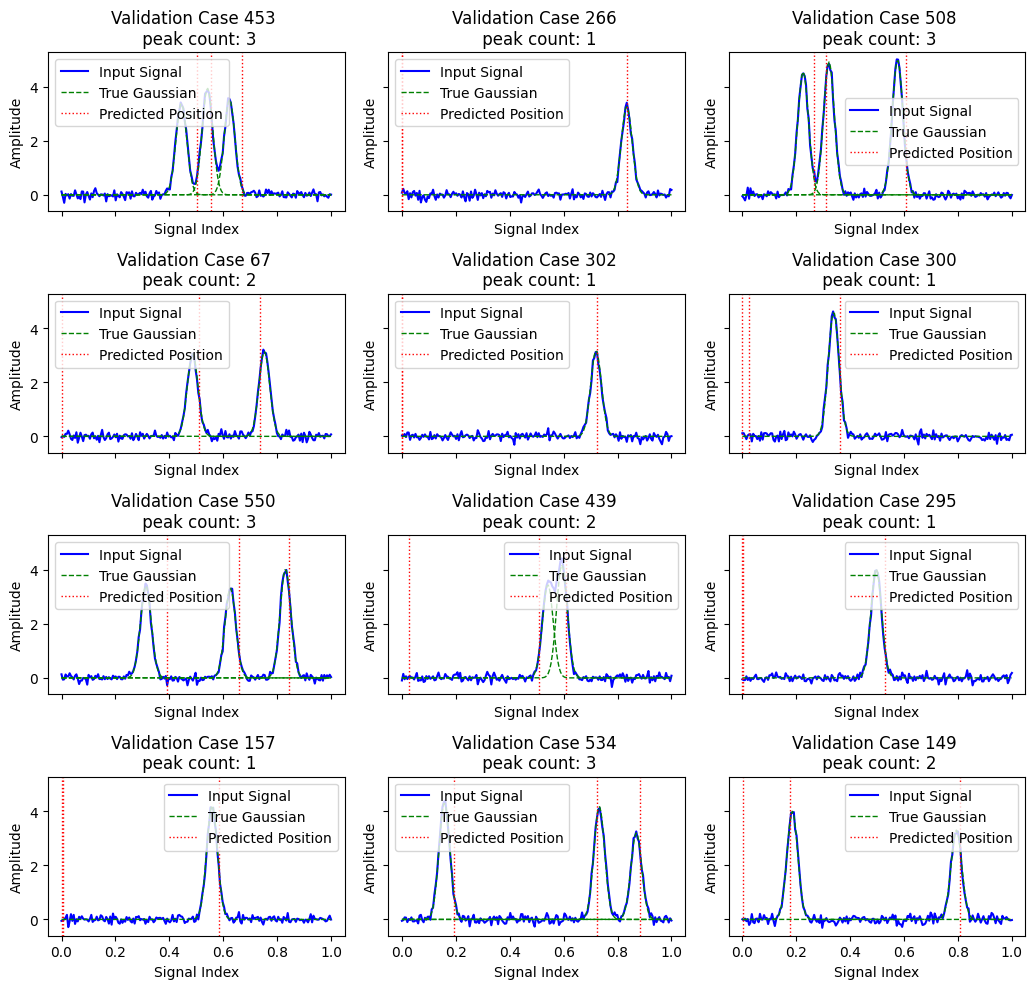

In [97]:

plot_training_history(history, filtering=['*loss*'])

visualize_validation_cases(
    model=model,
    validation_data=dataset['test'],
    sequence_length=200,
    num_examples=12,
    n_columns=3
)

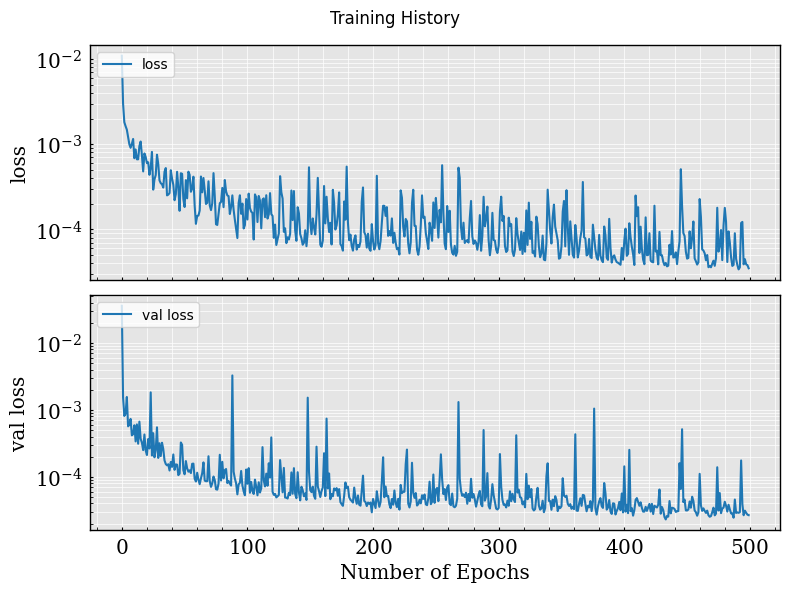

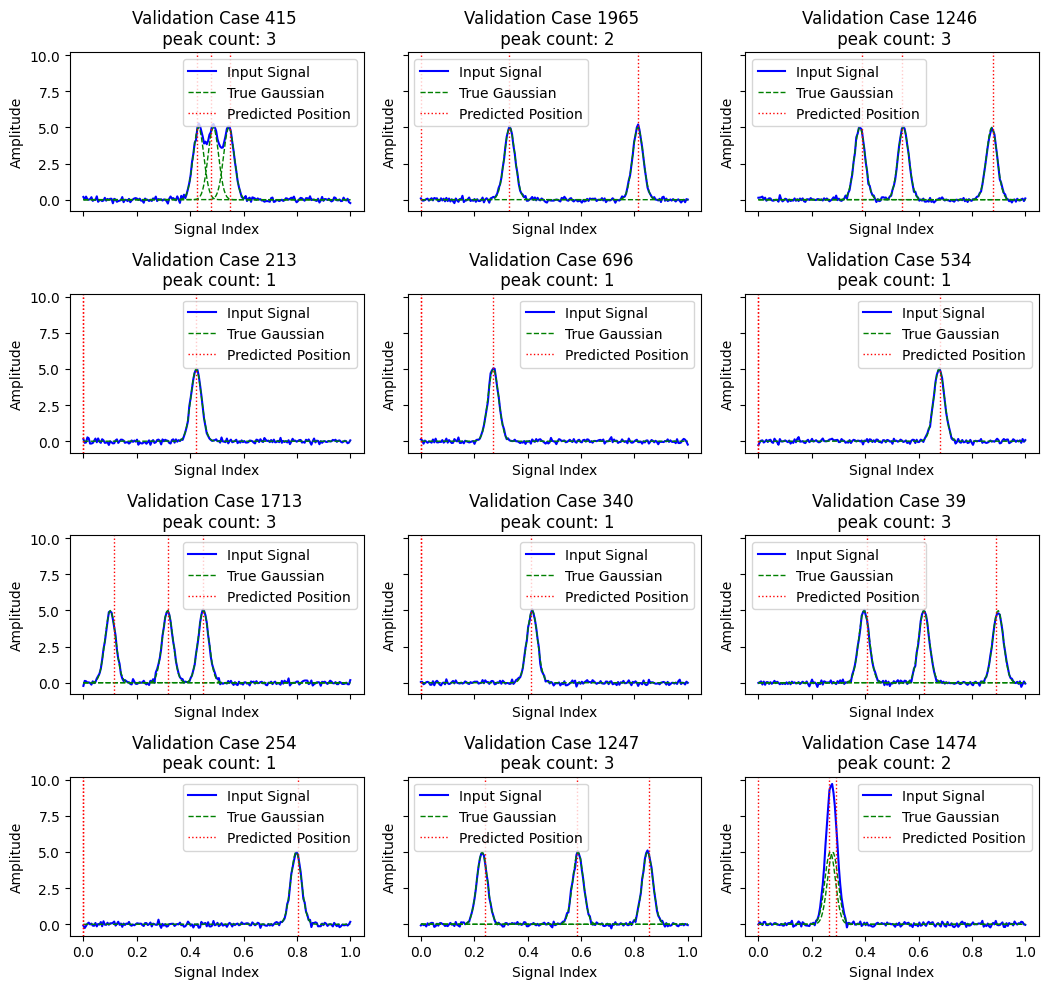

In [33]:

plot_training_history(history, filtering=['*loss*'])

visualize_validation_cases(
    model=model,
    validation_data=dataset['test'],
    sequence_length=200,
    num_examples=12,
    n_columns=3
)

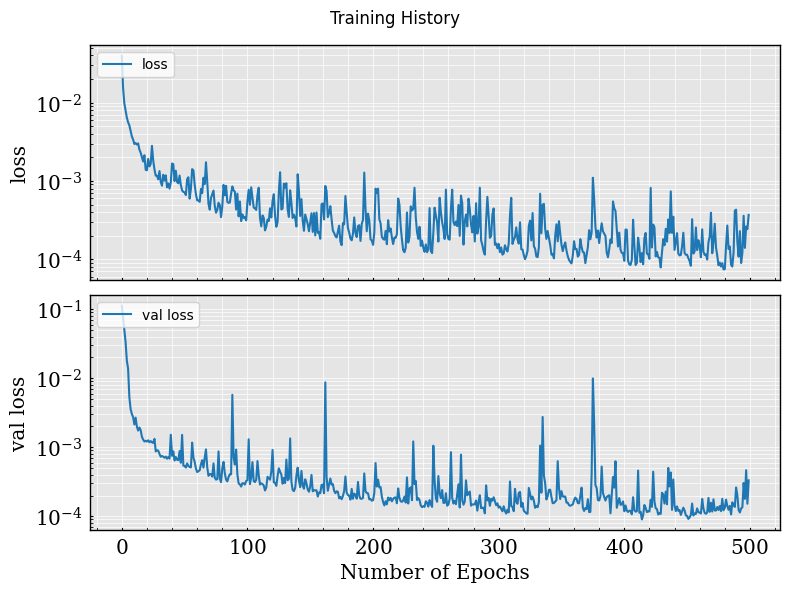

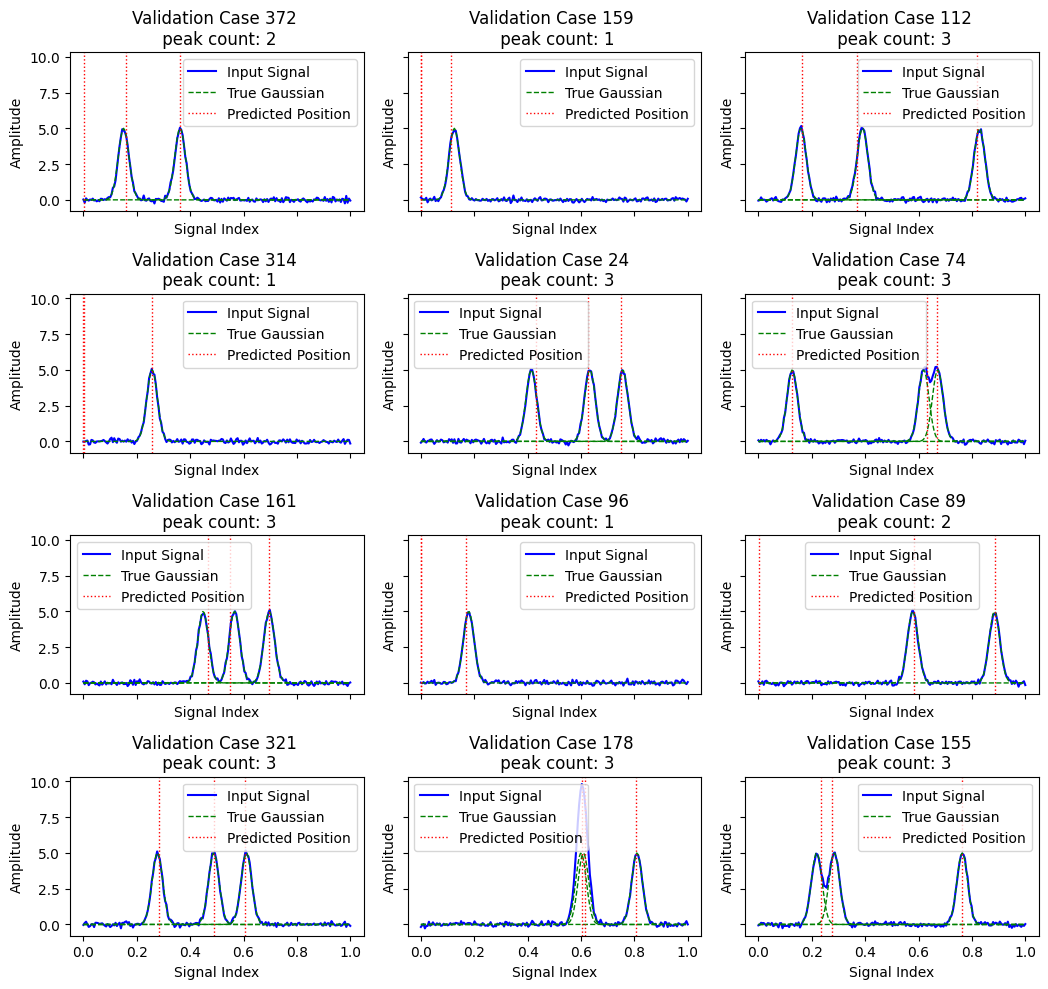

In [19]:

plot_training_history(history, filtering=['*loss*'])

visualize_validation_cases(
    model=model,
    validation_data=dataset['test'],
    sequence_length=200,
    num_examples=12,
    n_columns=3
)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

###############################################################################
# 1) CREATE THE MODEL (probability + amplitude output)
###############################################################################

def get_peak_map_model(
    input_length: int,
    base_filters: int = 32,
    kernel_size: int = 5
) -> tf.keras.Model:
    """
    A fully convolutional 1D model that outputs:
      channel 0 => Probability of peak at each index (via sigmoid)
      channel 1 => Amplitude at each index (linear)
    """
    input_layer = layers.Input(shape=(input_length, 1), name="input_signal")

    # Simple stack of Conv1D
    x = layers.Conv1D(filters=base_filters, kernel_size=kernel_size, 
                      padding="same", activation="relu")(input_layer)
    x = layers.Conv1D(filters=base_filters * 2, kernel_size=kernel_size, 
                      padding="same", activation="relu")(x)

    # Final conv to produce 2 channels
    x_out = layers.Conv1D(filters=2, kernel_size=1, 
                          padding="same", activation="linear")(x)

    # We only apply sigmoid to the first channel (probabilities)
    def split_and_activate(t):
        prob = tf.nn.sigmoid(t[..., 0:1])  # shape (batch, length, 1)
        amp  = t[..., 1:2]                 # shape (batch, length, 1)
        return tf.concat([prob, amp], axis=-1)

    output_layer = layers.Lambda(split_and_activate, name="prob_amp_output")(x_out)

    model = models.Model(inputs=input_layer, outputs=output_layer, name="peak_map_model")
    return model

###############################################################################
# 2) CREATE A CUSTOM LOSS
###############################################################################

def peak_map_loss_wrapper(prob_weight=1.0, amp_weight=1.0):
    """
    Returns a custom loss function that applies:
      - BCE for the probability channel
      - MSE for the amplitude channel (masked where ground truth prob=1)
    """
    bce = tf.keras.losses.BinaryCrossentropy(reduction='none')
    mse = tf.keras.losses.MeanSquaredError(reduction='none')
    
    def loss_fn(y_true, y_pred):
        # y_true, y_pred shape: (batch, length, 2)
        prob_true = y_true[..., 0]
        prob_pred = y_pred[..., 0]

        amp_true  = y_true[..., 1]
        amp_pred  = y_pred[..., 1]

        # 1) Probability loss => BCE
        prob_loss = bce(prob_true, prob_pred)  # (batch, length)

        # 2) Amplitude loss => MSE only where prob_true==1
        mask = tf.where(prob_true > 0, 1.0, 0.0)
        amp_loss = mse(amp_true * mask, amp_pred * mask)

        total_loss = prob_weight * tf.reduce_mean(prob_loss) \
                     + amp_weight * tf.reduce_mean(amp_loss)
        return total_loss
    
    return loss_fn


def compile_peak_map_model(
    model: tf.keras.Model, 
    prob_weight=1.0, 
    amp_weight=1.0, 
    lr=1e-3
):
    """
    Compiles the peak map model with our custom loss.
    """
    loss_fn = peak_map_loss_wrapper(prob_weight=prob_weight, amp_weight=amp_weight)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=loss_fn
    )
    return model

###############################################################################
# 3) GENERATE SYNTHETIC DATA (FOR DEMO PURPOSES)
###############################################################################

def generate_synthetic_data(
    num_samples: int,
    signal_length: int,
    max_peaks: int = 4,
    noise_level: float = 0.05,
    seed: int = 42
):
    """
    Generate random 1D signals with up to max_peaks Gaussian peaks.
    Returns:
      X: shape (num_samples, signal_length, 1), the noisy signals
      Y: shape (num_samples, signal_length, 2)
         channel 0 => 1 if there's a peak center, else 0
         channel 1 => amplitude at that center, else 0
    """
    rng = np.random.default_rng(seed)

    X = np.zeros((num_samples, signal_length), dtype=np.float32)
    Y = np.zeros((num_samples, signal_length, 2), dtype=np.float32)

    for i in range(num_samples):
        # Randomly choose how many peaks (0..max_peaks)
        peak_count = rng.integers(0, max_peaks+1)

        for _ in range(peak_count):
            peak_idx = rng.integers(0, signal_length)
            amp = rng.uniform(0.5, 1.5)  # random amplitude

            # Gaussian shape for the peak in the signal
            xs = np.arange(signal_length)
            std = 8.0
            gauss = amp * np.exp(-0.5 * ((xs - peak_idx)/std)**2)

            X[i] += gauss

            # ground truth: channel 0 => 1 at peak center, channel 1 => amplitude
            Y[i, peak_idx, 0] = 1
            Y[i, peak_idx, 1] = amp

        # Add random noise
        noise = rng.normal(0, noise_level, size=signal_length)
        X[i] += noise

    X = np.expand_dims(X, axis=-1)  # shape => (num_samples, length, 1)
    return X, Y

###############################################################################
# 4) PLOTTING FUNCTION
###############################################################################

def plot_signal_peaks(signal, prob, amp, gt_prob, gt_amp, sample_idx=None, threshold=0.5):
    """
    Plots:
      - The raw signal (top subplot).
      - The ground truth peaks (green circles).
      - The predicted peaks (red 'x').
      - The predicted probability map (bottom subplot) + threshold line.

    Parameters
    ----------
    signal : 1D np.array of shape (signal_length,)
        The raw time-domain signal to plot.
    prob : 1D np.array of shape (signal_length,)
        The predicted probability for each index.
    amp : 1D np.array of shape (signal_length,)
        The predicted amplitude for each index.
    gt_prob : 1D np.array of shape (signal_length,)
        Ground truth probability map (0 or 1).
    gt_amp : 1D np.array of shape (signal_length,)
        Ground truth amplitude map (non-zero at peak positions).
    sample_idx : int, optional
        If provided, will include the sample index in the title.
    threshold : float
        Probability threshold to decide if an index is a peak.
    """
    signal_length = len(signal)
    time = np.arange(signal_length)

    # Find predicted peaks where prob>threshold
    pred_peak_indices = np.where(prob > threshold)[0]
    pred_peak_amps = amp[pred_peak_indices]

    # Find true peaks where gt_prob>0.5
    true_peak_indices = np.where(gt_prob > 0.5)[0]
    true_peak_amps = gt_amp[true_peak_indices]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

    # --- Top subplot: signal + predicted vs. true peak positions ---
    ax1.plot(time, signal, label='Signal')
    if sample_idx is not None:
        ax1.set_title(f'Sample {sample_idx} | True vs. Predicted Peaks')
    else:
        ax1.set_title('True vs. Predicted Peaks')
    ax1.set_ylabel('Signal amplitude')
    
    # ground truth peaks in green circles
    ax1.scatter(true_peak_indices, true_peak_amps, 
                marker='o', facecolors='none', edgecolors='green', 
                label='True Peak')

    # predicted peaks in red 'x'
    ax1.scatter(pred_peak_indices, pred_peak_amps, 
                marker='x', color='red', 
                label='Predicted Peak')
    ax1.legend(loc='upper right')

    # --- Bottom subplot: predicted probability + threshold line ---
    ax2.plot(time, prob, label='Predicted Probability', color='orange')
    ax2.axhline(threshold, color='red', linestyle='--', alpha=0.5, 
                label=f'Threshold={threshold}')
    ax2.set_xlabel('Index')
    ax2.set_ylabel('Probability')
    ax2.legend(loc='upper right')

    plt.tight_layout()
    plt.show()


###############################################################################
# 5) DEMO: TRAIN, EVALUATE, AND PLOT
###############################################################################

if __name__ == "__main__":
    # Hyperparameters
    signal_length = 128
    num_train = 1000
    num_test  = 200
    epochs    = 10
    batch_size= 32

    # Generate training / test data
    X_train, Y_train = generate_synthetic_data(num_train, signal_length, seed=42)
    X_test,  Y_test  = generate_synthetic_data(num_test,  signal_length, seed=999)

    # Build & compile model
    model = get_peak_map_model(input_length=signal_length)
    compile_peak_map_model(model, prob_weight=1.0, amp_weight=1.0, lr=1e-3)
    model.summary()

    # Train
    model.fit(
        X_train,
        Y_train,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size
    )

    # Evaluate
    test_loss = model.evaluate(X_test, Y_test, verbose=0)
    print(f"Final test loss: {test_loss:.4f}")

    # Predict on a small subset of test data
    num_plot = 3  # number of samples to plot
    X_plot = X_test[:num_plot]
    Y_plot = Y_test[:num_plot]

    predictions = model.predict(X_plot)  # shape => (num_plot, length, 2)
    # prob channel => predictions[...,0], amp channel => predictions[...,1]

    # Plot each sample using the new function
    for i in range(num_plot):
        signal  = X_plot[i, :, 0]      # shape => (128,)
        prob    = predictions[i, :, 0] # predicted probability
        amp     = predictions[i, :, 1] # predicted amplitude
        gt_prob = Y_plot[i, :, 0]
        gt_amp  = Y_plot[i, :, 1]

        plot_signal_peaks(
            signal=signal,
            prob=prob,
            amp=amp,
            gt_prob=gt_prob,
            gt_amp=gt_amp,
            sample_idx=i,        # optional
            threshold=0.5        # can tune the threshold
        )


In [ ]:
from typing import Tuple
import numpy as np
from tensorflow.keras.utils import to_categorical  # type: ignore


def generate_gaussian_dataset(
    sample_count: int,
    sequence_length: int,
    peak_count: tuple | int = (1, 5),
    amplitude_range: tuple | float=(1, 5),
    center_range: tuple | float = (32, 96),
    width_range: tuple | float = (5, 20),
    noise_std: float = 0.0,
    normalize: bool = True,
    normalize_x: bool = True,
    nan_values: float = 0,
    categorical_peak_count: bool = True) -> Tuple:
    """
    Generate a dataset of Gaussian curves with optional Gaussian noise.

    Parameters
    ----------
    sample_count : int
        Number of sequences to generate.
    sequence_length : int
        Length of each sequence.
    peak_count : int or tuple of int
        Number of Gaussian peaks per sequence (fixed or random range).
    amplitude_range : tuple of float or float
        Range or fixed value for amplitudes of Gaussian peaks.
    center_range : tuple of int or int
        Range or fixed value for center positions of Gaussian peaks.
    width_range : tuple of float or float
        Range or fixed value for standard deviations (widths) of Gaussian peaks.
    noise_std : float
        Standard deviation of Gaussian noise added to each sequence.
    normalize : bool
        Whether to normalize each sequence.

    Returns
    -------
    signals : numpy.ndarray
        Array of sequences with Gaussian peaks and added noise, shape (sample_count, sequence_length, 1).
    amplitudes : numpy.ndarray
        Array of amplitudes for each peak, shape (sample_count, max_peaks).
    peak_counts : numpy.ndarray
        Number of peaks per sequence, shape (sample_count,).
    peak_positions : numpy.ndarray
        Positions of peaks, shape (sample_count, max_peaks).
    peak_widths : numpy.ndarray
        Widths of peaks, shape (sample_count, max_peaks).
    """
    if isinstance(peak_count, tuple):
        min_peaks, max_peaks = peak_count
    else:
        min_peaks = max_peaks = peak_count

    if isinstance(amplitude_range, (int, float)):
        amplitude_range = (amplitude_range, amplitude_range)

    if isinstance(center_range, (int, float)):
        center_range = (center_range, center_range)

    if isinstance(width_range, (int, float)):
        width_range = (width_range, width_range)

    max_peaks = max(max_peaks, 1)  # Ensure at least one peak
    if normalize_x:
        x_values = np.linspace(0, 1, sequence_length)
    else:
        x_values = np.arange(sequence_length)  # Shared x-axis for all sequences

    # Preallocate arrays
    signals = np.zeros((sample_count, sequence_length, 1))
    amplitudes = np.zeros((sample_count, max_peaks)) * nan_values
    peak_positions = np.zeros((sample_count, max_peaks)) * nan_values
    peak_widths = np.zeros((sample_count, max_peaks)) * nan_values
    peak_counts = np.zeros((sample_count), dtype=int)

    # Generate Gaussian parameters
    for i in range(sample_count):
        current_peak_count = np.random.randint(min_peaks, max_peaks + 1)

        current_amplitudes = np.random.uniform(amplitude_range[0], amplitude_range[1], size=current_peak_count)
        current_centers = np.random.uniform(center_range[0], center_range[1], size=current_peak_count)
        current_widths = np.random.uniform(width_range[0], width_range[1], size=current_peak_count)

        # Compute Gaussian curves in vectorized form
        gaussians = current_amplitudes[:, None] * np.exp(-((x_values - current_centers[:, None])**2) / (2 * current_widths[:, None]**2))
        combined_curve = np.sum(gaussians, axis=0)

        # Add Gaussian noise if applicable
        if noise_std > 0:
            combined_curve += np.random.normal(0, noise_std, sequence_length)

        if normalize:
            combined_curve = (combined_curve - np.mean(combined_curve)) / np.std(combined_curve)

        # Store results
        signals[i, :, 0] = combined_curve
        amplitudes[i, :current_peak_count] = current_amplitudes
        peak_positions[i, :current_peak_count] = current_centers
        peak_widths[i, :current_peak_count] = current_widths
        peak_counts[i] = current_peak_count

    # Sort peaks by positions
    sorted_indices = np.argsort(peak_positions, axis=1)
    amplitudes = np.take_along_axis(amplitudes, sorted_indices, axis=1)
    peak_widths = np.take_along_axis(peak_widths, sorted_indices, axis=1)
    peak_positions = np.take_along_axis(peak_positions, sorted_indices, axis=1)

    if categorical_peak_count:
        peak_counts = to_categorical(peak_counts, max_peaks + 1)

    return signals, amplitudes, peak_counts, peak_positions, peak_widths, x_values



slices, amplitudes, peak_count, positions, widths, _ = generate_gaussian_dataset(
    sample_count=3000,
    sequence_length=200,
    peak_count=(1, 4),
    amplitude_range=(5, 5),
    center_range=(0.1, 0.9),
    width_range=(0.02, 0.025),
    noise_std=0.2,
    normalize=True,
    normalize_x=True,
    categorical_peak_count=True
)

import matplotlib.pyplot as plt
def plot_dataset(data, indices: tuple):
    
    figure, axes = plt.subplots(ncols=1, nrows=len(indices))
    for (ax, index) in zip(axes, indices):
        
        ax.plot(data[index].squeeze())

    plt.tight_layout()
    plt.show()

plot_dataset(slices, indices=[0, 1])

In [67]:
dir(keras.losses)

['BinaryCrossentropy',
 'BinaryFocalCrossentropy',
 'CTC',
 'CategoricalCrossentropy',
 'CategoricalFocalCrossentropy',
 'CategoricalHinge',
 'Circle',
 'CosineSimilarity',
 'Dice',
 'Hinge',
 'Huber',
 'KLD',
 'KLDivergence',
 'LogCosh',
 'Loss',
 'MAE',
 'MAPE',
 'MSE',
 'MSLE',
 'MeanAbsoluteError',
 'MeanAbsolutePercentageError',
 'MeanSquaredError',
 'MeanSquaredLogarithmicError',
 'Poisson',
 'Reduction',
 'SparseCategoricalCrossentropy',
 'SquaredHinge',
 'Tversky',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'binary_crossentropy',
 'binary_focal_crossentropy',
 'categorical_crossentropy',
 'categorical_focal_crossentropy',
 'categorical_hinge',
 'circle',
 'cosine_similarity',
 'ctc',
 'deserialize',
 'dice',
 'get',
 'hinge',
 'huber',
 'kld',
 'kullback_leibler_divergence',
 'logcosh',
 'mae',
 'mape',
 'mse',
 'msle',
 'poisson',
 'serialize',
 'sparse_categorical_crossentropy',
 'squared_hin